#### **This notebook contains the functions used to clean the spectra and evalutate model performance.**

Import Libraries

In [1]:
import sys
sys.path.append('..')
from Cleaning_and_Evaluation import *
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns

Read the spectral data

In [3]:
#df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")

In [4]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
4638931,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
4638932,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
4638933,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
4638934,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


> Pivot the dataframe using WaveNumbers as features.

In [5]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    statuses = df[['SpecID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

>Scale the absorbances to the highest peak in each spectrum.

In [6]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

>Scale the absorbances to the norm of the absorbances.

In [7]:
def vector_normalise(absorbances):
    l2_norm = np.sqrt(np.sum(absorbances**2))  # Calculate the euclidean norm
    normalized_absorbances = absorbances / l2_norm
    return normalized_absorbances

In [8]:
def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarisation threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if it has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=20)
    return(despiked_absorbance)

#df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

>Calculate the baseline using Asymmetric Least Squares, then subtract it from the spectrum.

In [9]:
from pybaselines.whittaker import asls

def asls_baseline_correction(x, lam, p):
        corrected, _ = asls(x, lam=lam, p=p)
        return corrected

#### **Select the chosen cleaning parameters then run the functions**

Choose the Parameters

In [10]:
# # Best Full Spectrum Parameters

# lam = 10 ** 7
# p = 0.05
# window_size = 51
# poly_order = 2

# Best 400-1800 Parameters

lam = 10 ** 9
p = 0.05
window_size = 45
poly_order = 2

#### **Here is an example on 1 spectrum**

In [11]:
sample = df[df['SpecID'] == "210526-3-05"]

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

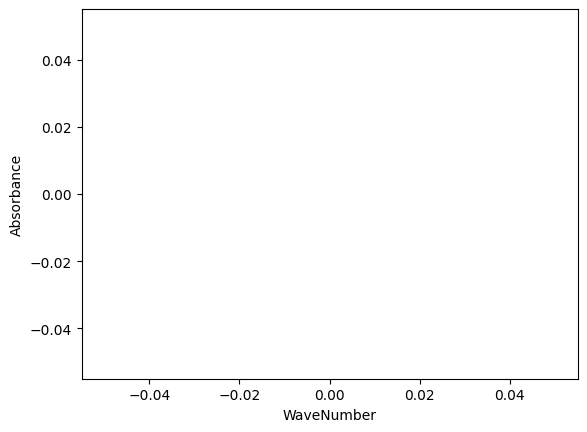

In [12]:
sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)

Subtract the baseline.

<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

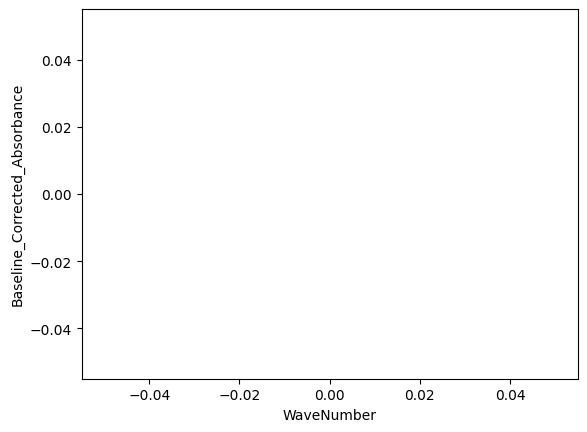

In [13]:
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Smooth the Baseline_Corrected_Spectrum

<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

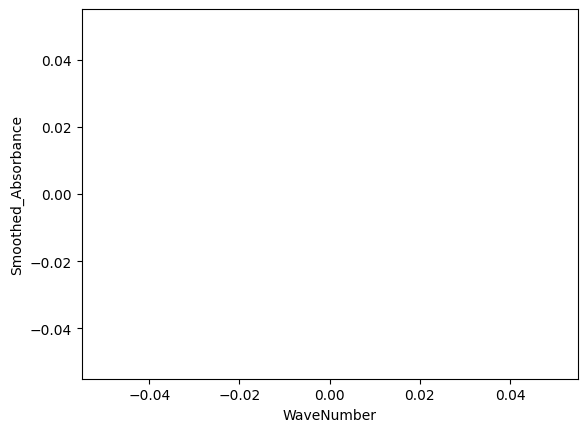

In [14]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

In [15]:
# # Despike

# df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [16]:
df['Baseline'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))

In [17]:
df['Baseline_Corrected_Absorbance'] = df['Absorbance'] - df['Baseline']

In [18]:
df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [19]:
# Optional Scaling
# df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Smooth_Baseline_Corrected'].transform(lambda x: normalise(x))
# df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Smooth_Baseline_Corrected'].transform(lambda x: vector_normalise(x))

In [20]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Baseline,Baseline_Corrected_Absorbance,Smooth_Baseline_Corrected
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,1732.452672,33.210128,32.316184
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,1732.301559,42.479341,32.229535
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,1732.150446,36.879754,32.142799
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,1731.999334,24.422666,32.055975
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,1731.848221,27.020779,31.969064
...,...,...,...,...,...,...,...,...,...
4638931,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,1647.373859,-29.981259,-16.873032
4638932,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,1646.546387,-13.455287,-15.976760
4638933,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,1645.718915,-12.411315,-15.040871
4638934,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,1644.891442,-3.024942,-14.065367


In [21]:
df = df.drop(columns=['Absorbance', 'Baseline', 'Baseline_Corrected_Absorbance'])
df = df.rename(columns={'Smooth_Baseline_Corrected':'Absorbance'})

In [22]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,32.316184
1,201210-1-00,294,400.91116,201210-1,Normal,32.229535
2,201210-1-00,295,401.59454,201210-1,Normal,32.142799
3,201210-1-00,296,402.27789,201210-1,Normal,32.055975
4,201210-1-00,297,402.96127,201210-1,Normal,31.969064
...,...,...,...,...,...,...
4638931,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-16.873032
4638932,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-15.976760
4638933,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-15.040871
4638934,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-14.065367


#### **Evaluate Extra Trees Classifier**

In [23]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_validate, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [24]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [25]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = cross_validate(et, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    # Displaying the results
    print(f"{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [26]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [27]:
evaluate_extra_trees(wavelength_df)

/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.6377 +/- 0.1205
ExtraTreesClassifier Cross-Validation Precision: 0.5867 +/- 0.1114
ExtraTreesClassifier Cross-Validation Recall: 0.5767 +/- 0.1251
ExtraTreesClassifier Cross-Validation F1-Score: 0.5572 +/- 0.1178


#### **Show metrics by class**

In [28]:
def evaluate_extra_trees_by_class(df):

    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']
    
    # Get unique class names from the 'y' dataset
    class_names = y.unique()

    et = ExtraTreesClassifier(random_state=1234)
    cv = GroupKFold(n_splits=10)

    accuracies = []
    precisions = [[] for _ in class_names]
    recalls = [[] for _ in class_names]
    f1_scores = [[] for _ in class_names]

    for train_idx, test_idx in cv.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        et.fit(X_train, y_train)
        y_pred = et.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, zero_division=0, labels=class_names)
        for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
            precisions[i].append(p)
            recalls[i].append(r)
            f1_scores[i].append(f)

    print(f"{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(accuracies):.4f} +/- {np.std(accuracies):.4f}\n")
    for i, class_name in enumerate(class_names):
        print(f"{class_name} Precision: {np.mean(precisions[i]):.4f} +/- {np.std(precisions[i]):.4f}")
        print(f"{class_name} Recall: {np.mean(recalls[i]):.4f} +/- {np.std(recalls[i]):.4f}")
        print(f"{class_name} F1-Score: {np.mean(f1_scores[i]):.4f} +/- {np.std(f1_scores[i]):.4f}\n")


In [29]:
evaluate_extra_trees_by_class(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6377 +/- 0.1205

Normal Precision: 0.5685 +/- 0.2477
Normal Recall: 0.5724 +/- 0.3099
Normal F1-Score: 0.5549 +/- 0.2545

Hyperglycemia Precision: 0.5825 +/- 0.2048
Hyperglycemia Recall: 0.6148 +/- 0.1908
Hyperglycemia F1-Score: 0.5862 +/- 0.1760

Hypoglycemia Precision: 0.6092 +/- 0.2771
Hypoglycemia Recall: 0.5427 +/- 0.3242
Hypoglycemia F1-Score: 0.5305 +/- 0.2829



#### **Predict the Surface Status By the Combined Predictions of its Spectra**

In [30]:
surface_statuses = df.groupby("SurID")['Status'].first().rename('Status')
surface_statuses

SurID
201210-1           Normal
201210-2           Normal
210114-1           Normal
210114-2           Normal
210120-1    Hyperglycemia
                ...      
210519-3    Hyperglycemia
210524-1     Hypoglycemia
210526-1    Hyperglycemia
210526-2    Hyperglycemia
210526-3    Hyperglycemia
Name: Status, Length: 63, dtype: object

In [31]:
from collections import Counter
from sklearn.metrics import classification_report

def predict_surface_from_spectra(df):
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    et = ExtraTreesClassifier(random_state=1234)
    cv = GroupKFold(n_splits=10)
    
    # Dictionary to collect predictions for each group
    group_predictions = {group: [] for group in groups.unique()}
    
    for train_idx, test_idx in cv.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        test_groups = groups.iloc[test_idx]

        et.fit(X_train, y_train)
        y_pred = et.predict(X_test)

        # Collect predictions
        for group, prediction in zip(test_groups, y_pred):
            group_predictions[group].append(prediction)
    
    # Determine the most common prediction for each group
    group_status = {group: Counter(predictions).most_common(1)[0][0] for group, predictions in group_predictions.items()}

    # Convert the predicted status dictionary to a DataFrame
    predicted_status_df = pd.DataFrame(list(group_status.items()), columns=['SurID', 'PredictedStatus'])

    # Compare the real and predicted Status of each group
    merged_df = pd.merge(surface_statuses, predicted_status_df, on='SurID')

    y_true, y_pred = merged_df['Status'], merged_df['PredictedStatus']
    print(classification_report(y_true, y_pred))

In [32]:
group_predicted_status = predict_surface_from_spectra(wavelength_df)

               precision    recall  f1-score   support

Hyperglycemia       0.64      0.74      0.68        19
 Hypoglycemia       0.68      0.59      0.63        22
       Normal       0.68      0.68      0.68        22

     accuracy                           0.67        63
    macro avg       0.67      0.67      0.67        63
 weighted avg       0.67      0.67      0.67        63

